# TOF Scan Visualizer

Welcome to the TOF Scan Visualizer notebook. This notebook can help you with plotting averaged tof spectra and using them to plot integrals over specified ranges of them over scan variables

As of now this notebook assumes that for each scan position a seperate run has been recorded.

Some of the here developed functions should be migrated into sqs_nqs_tools.offline.tof at some point.

In [1]:
%matplotlib notebook
import sqs_nqs_tools as nqs
from sqs_nqs_tools.offline import access, adata, tof

# Plot options
import matplotlib.pyplot as plt

# Import required libraries
import numpy as np 
from types import MappingProxyType

# Import karabo libraries
import karabo_bridge as kb
import karabo_data as kd



Welcome to sqs_nqs_tools version v0.1+92.g4579c4d.dirty


Initialize empty dictionary object for temp storage of TOF AVG traces

In [2]:
tof_avg_traces_temp_stor = dict()

# Basic Configuration

In [3]:
raw_path ='/gpfs/exfel/exp/SQS/201802/p002195/raw'
_samples = 16 #number of combined tof channels

Function to Load a TOF AVG

In [4]:
def get_tof_avg(run_no, path=raw_path):
    key = str(run_no)
    # check if run number already available in tmp storage dictionary, if so just return it from there
    if key in tof_avg_traces_temp_stor:
        pass
    else:
        print("read from HDF5 - run: "+key)
        [TOFtrace, TOFrange] = adata.getTOF(run_no, path=path, fullrange=True)
        TOFavg = tof.averageTOF(TOFtrace)
        tof_avg_traces_temp_stor[key] = {'range': TOFrange, 'trace': TOFavg}
    # need to return copy of arrays, since otherwise temporary stored variables may be changed due to processing
    # dicts and np arrays are mutable!!
    return np.copy(tof_avg_traces_temp_stor[key]['range']),np.copy(tof_avg_traces_temp_stor[key]['trace'])
    
    
def plot_tof_avgs(run_no_list, path=raw_path, xlim='auto', alpha=1, downsampling_to_single_digitizer=False,plt_style='-', bg=None):
    plt.figure()
    for run_no in run_no_list:
        tof_range, tof_trace = get_tof_avg(run_no, path=path)
        tof_range, tof_trace = tof_data_processing(tof_range,tof_trace,downsampling_to_single_digitizer, bg=bg)                                                            
        plt.plot(tof_range,tof_trace,plt_style,label=str(run_no), alpha = alpha)
    if xlim is not 'auto':
        plt.xlim(xlim)
    downsampling_warning_plot_title(downsampling_to_single_digitizer)
    plt.legend()
    plt.grid()
    plt.show()

def get_integral(run_no,path=raw_path, x_range='full', downsampling_to_single_digitizer=False, bg = None):
    tof_range, tof_trace = get_tof_avg(run_no, path=path)
    tof_range, tof_trace = tof_data_processing(tof_range,tof_trace,downsampling_to_single_digitizer, bg=bg)                                                            
    if x_range == 'full':
        x_range = [np.min(tof_range), np.max(tof_range)]
    integral_idx = (tof_range > x_range[0]) * (tof_range < x_range[1])
    integral = np.sum(tof_trace[integral_idx])
    return float(integral)

def get_integrals(run_no_list,path=raw_path, x_ranges=['full'], downsampling_to_single_digitizer=False, bg = None):
    integral_array = np.zeros(shape=(len(run_no_list),len(x_ranges)))
    for idx in range(len(run_no_list)):
        run_no = run_no_list[idx]
        for idx_range in range(len(x_ranges)):
            x_range = x_ranges[idx_range]
            integral = get_integral(run_no,path=path, x_range=x_range, downsampling_to_single_digitizer=downsampling_to_single_digitizer, bg=bg )
            integral_array[idx,idx_range] = integral
        
    return integral_array

def plot_integral_scan(runs, x_range_list, scan_axis='runs', downsampling_to_single_digitizer=False, bg=None):
    if scan_axis == 'runs':
        scan_axis = runs
        
    integral_array = get_integrals(runs, x_ranges=x_range_list, downsampling_to_single_digitizer=downsampling_to_single_digitizer, bg=bg)
    
    plt.figure()
    for i in range(integral_array.shape[1]):
        plt.plot(scan_axis,integral_array[:,i], 'o', label=str(x_range_list[i]))
    plt.legend()
    downsampling_warning_plot_title(downsampling_to_single_digitizer)
    plt.grid()
    plt.show()
    
def get_1d_data_downsampling_to_single_digitizer(data, bg=None, samples=_samples):
    data_idx_selection = np.arange(0,len(data),samples)
    data = data[data_idx_selection]
    if bg is not None:
        data = data - np.mean(data[int(np.floor(bg[0]/samples)):int(np.floor(bg[1]/samples))])
    return data

def downsampling_warning_str(samples=_samples):
    return "Plot based on every "+str(samples)+"th point of TOF trace data!!!"
def downsampling_warning_plot_title(downsampling_to_single_digitizer):
    if downsampling_to_single_digitizer:
        plt.title(downsampling_warning_str())
def tof_data_processing(tof_range,tof_trace,downsampling, bg=None):
    if downsampling:
        tof_range=get_1d_data_downsampling_to_single_digitizer( tof_range)
        tof_trace=get_1d_data_downsampling_to_single_digitizer( tof_trace, bg=bg )
    else:
        tof_trace=tof.get_TOF_correction_for_multi_channel_sampling( tof_trace, bg=bg )
    return tof_range,tof_trace

Plot AVG TOF Traces from various runs on top of each other:

**Arguments:**<br>
A list of runs you are interested in (eg. `[1,2,5]`) for runs 1, 2 and 5

**Optional (keyword) arguments:**<br>
* `xlim` - specify xlimits default: `'auto'`, hard limits in the format `(leftlimit, rightlimit)`<br>
* `alpha` - specify an alpha (transparency) for overlays - default `1` (no transparency)<br>
* `downsampling_to_single_digitizer` - default: `False`, if `True` only every 8th point is plotted, this removes artificial noise created by different offsets of contributing (8) channels, maybe also 16 depending on setting of variable `_samples`<br>
* `bg` - option to specify range where a "zero" can be obtained, this way when downsampling is disabled, but `bg` is set (default: `None`) all _sample channels that have different offsets are processed such that the offset is removed <br>
**NOTE: there shall not be any signal withing the specified bg range!**

<IPython.core.display.Javascript object>


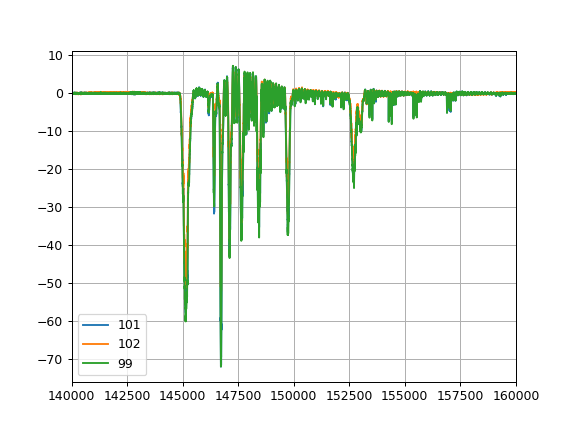

read from HDF5 - run: 101
read from HDF5 - run: 102
read from HDF5 - run: 99


In [5]:
plot_tof_avgs([101,102,99],xlim=(140000,160000),downsampling_to_single_digitizer=False,plt_style='-',  bg=[0,50000])

## Plot Integrals vs scan axis

here we assume that a single run contains only a single scan position!

**plot_integral_scan(runs, x_range_list, scan_axis='runs', downsampling_to_single_digitizer=True)**

`x_range_list` - is a list of integration ranges each may is specified as `[min_x, max_x]` or `'full'`
`runs` - A list of runs you are interested in (eg. `[1,2,5]`) for runs 1, 2 and 5
<br><br>
`scan_axis` - values for scan axis in the order of `runs` input parameter, or `'runs'` which makes the input for `runs` the scan axis (default)


read from HDF5 - run: 105


<IPython.core.display.Javascript object>


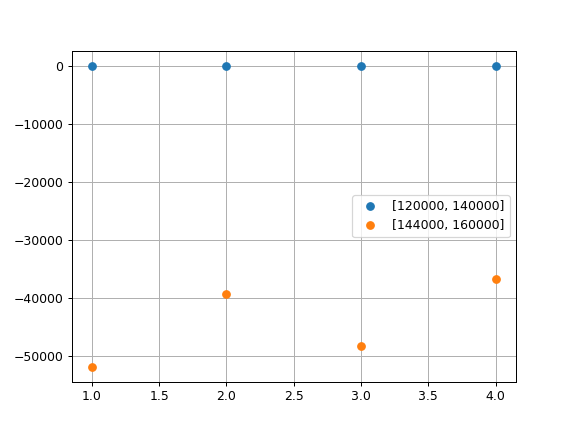

In [6]:
runs = [101,102,103,105]
dummy_scan_axis = [1,2,3,4]
x_range_list = [[120000,140000], [144000,160000] ]




plot_integral_scan(runs, x_range_list, scan_axis=dummy_scan_axis, downsampling_to_single_digitizer=False, bg=[0,50000])
